<a href="https://colab.research.google.com/github/ajaym416/GAN/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ajaypyatha","key":"47118be17f03eb8a083ea612f6a31172"}'}

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Layer

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from functools import partial

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt

def grad(y, x):
    V = Lambda(lambda z: K.gradients(
        z[0], z[1]), output_shape=[1])([y, x])
    return V

class RandomWeightedAverage(Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""
    def call(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , grad_weight
        , z_dim
        , batch_size
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02) # 'he_normal' #RandomNormal(mean=0., stddev=0.02)
        self.grad_weight = grad_weight
        self.batch_size = batch_size


        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self._build_critic()
        self._build_generator()

        self._build_adversarial()

            

    def gradient_penalty_loss(self, y_true, y_pred, interpolated_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = grad(y_pred, interpolated_samples)[0]

        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

    def wasserstein(self, y_true, y_pred):
        return -K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)

    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
        
        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                
            else:
                x = Activation('tanh')(x)

        generator_output = x
        self.generator = Model(generator_input, generator_output)




    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti


    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val

    def _build_adversarial(self):
                
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.set_trainable(self.generator, False)

        # Image input (real sample)
        real_img = Input(shape=self.input_dim)

        # Fake image
        z_disc = Input(shape=(self.z_dim,))
        fake_img = self.generator(z_disc)

        # critic determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'interpolated_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(
            loss=[self.wasserstein,self.wasserstein, partial_gp_loss]
            ,optimizer=self.get_opti(self.critic_learning_rate)
            ,loss_weights=[1, 1, self.grad_weight]
            )
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.set_trainable(self.critic, False)
        self.set_trainable(self.generator, True)

        # Sampled noise for input to generator
        model_input = Input(shape=(self.z_dim,))
        # Generate images based of noise
        img = self.generator(model_input)
        # Discriminator determines validity
        model_output = self.critic(img)
        # Defines generator model
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate)
        , loss=self.wasserstein
        )

        self.set_trainable(self.critic, True)

    def train_critic(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1), dtype=np.float32)
        fake = -np.ones((batch_size,1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32) # Dummy gt for gradient penalty

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
    
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))

        d_loss = self.critic_model.train_on_batch([true_imgs, noise], [valid, fake, dummy])
        return d_loss

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1), dtype=np.float32)
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
    , n_critic = 5
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            if epoch % 100 == 0:
                critic_loops = 5
            else:
                critic_loops = n_critic

            for _ in range(critic_loops):
                d_loss = self.train_critic(x_train, batch_size, using_generator)

            g_loss = self.train_generator(batch_size)

            
            print ("%d (%d, %d) [D loss: (%.1f)(R %.1f, F %.1f, G %.1f)] [G loss: %.1f]" % (epoch, critic_loops, 1, d_loss[0], d_loss[1],d_loss[2],d_loss[3],g_loss))
            


            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
                

            self.epoch+=1


    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.grad_weight
                    , self.z_dim
                    , self.batch_size
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def load_celeb(data_name, image_size, batch_size):
    # data_folder = os.path.join("./data", data_name)
    data_folder = data_name
    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x_train = data_gen.flow_from_directory(data_folder
                                            , target_size = (image_size,image_size)
                                            , batch_size = batch_size
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                                )

    return x_train

In [4]:
#Downloading the CelebA dataset from the kaggle
!pip install -q kaggle
!chmod 600 /content/kaggle.json
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:09<00:00, 138MB/s]
100% 1.33G/1.33G [00:09<00:00, 146MB/s]


In [5]:
import shutil
shutil.unpack_archive("/content/celeba-dataset.zip")

In [6]:
# run params
SECTION = 'gan'
RUN_ID = '0003'
DATA_NAME = 'celeb'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

os.makedirs(RUN_FOLDER,exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'viz'),exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'images'),exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'weights'),exist_ok=True)

mode =  'build' #'load' #

In [7]:
BATCH_SIZE = 64
IMAGE_SIZE = 64
DATA_NAME="/content/img_align_celeba/"

In [8]:
x_train = load_celeb(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)


Found 202599 images belonging to 1 classes.


In [9]:
x_train[0][0][0]


array([[[ 0.15294118,  0.78039217,  0.9607843 ],
        [ 0.19215687,  0.84313726,  0.9843137 ],
        [ 0.21568628,  0.8666667 ,  0.99215686],
        ...,
        [-0.5058824 ,  0.3019608 ,  1.        ],
        [-0.45882353,  0.33333334,  1.        ],
        [-0.4509804 ,  0.39607844,  0.9843137 ]],

       [[ 0.12941177,  0.7490196 ,  0.9843137 ],
        [ 0.16862746,  0.8117647 ,  0.9843137 ],
        [ 0.19215687,  0.84313726,  0.9843137 ],
        ...,
        [-0.49019608,  0.3254902 ,  1.        ],
        [-0.45882353,  0.33333334,  1.        ],
        [-0.44313726,  0.3882353 ,  0.9843137 ]],

       [[ 0.13725491,  0.75686276,  1.        ],
        [ 0.14509805,  0.78039217,  0.99215686],
        [ 0.18431373,  0.827451  ,  0.99215686],
        ...,
        [-0.46666667,  0.35686275,  1.        ],
        [-0.4509804 ,  0.34901962,  1.        ],
        [-0.44313726,  0.3647059 ,  0.96862745]],

       ...,

       [[ 0.6627451 ,  1.        ,  1.        ],
        [ 0

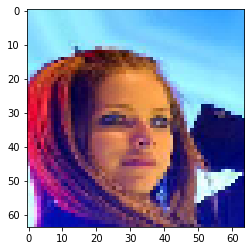

In [10]:
plt.imshow((x_train[0][0][0]+1)/2)


In [11]:
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )
if mode == 'build':
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
gan.critic.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 critic_conv_0 (Conv2D)      multiple                  4864      
                                                                 
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 critic_conv_1 (Conv2D)      multiple                  204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   multiple                  0         
                                                                 
 critic_conv_2 (Conv2D)      multiple                  819456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   multiple                  0     

In [13]:
gan.critic.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 critic_conv_0 (Conv2D)      multiple                  4864      
                                                                 
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 critic_conv_1 (Conv2D)      multiple                  204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   multiple                  0         
                                                                 
 critic_conv_2 (Conv2D)      multiple                  819456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   multiple                  0     

In [14]:
EPOCHS = 3000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
BATCH_SIZE = 64

In [15]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

0 (5, 1) [D loss: (-3.2)(R -8.4, F 0.1, G 0.5)] [G loss: -4.2]


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1 (5, 1) [D loss: (-98.1)(R -165.4, F 1.8, G 6.5)] [G loss: -45.5]
2 (5, 1) [D loss: (-133.1)(R -206.5, F 3.0, G 7.0)] [G loss: -61.1]
3 (5, 1) [D loss: (-142.7)(R -212.1, F 4.0, G 6.5)] [G loss: -74.7]
4 (5, 1) [D loss: (-143.0)(R -235.2, F 6.5, G 8.6)] [G loss: -73.8]
5 (5, 1) [D loss: (-146.3)(R -251.9, F 9.5, G 9.6)] [G loss: -72.7]
6 (5, 1) [D loss: (-135.8)(R -252.4, F 13.5, G 10.3)] [G loss: -71.6]
7 (5, 1) [D loss: (-146.5)(R -260.2, F 15.2, G 9.9)] [G loss: -76.5]
8 (5, 1) [D loss: (-159.4)(R -241.0, F 13.4, G 6.8)] [G loss: -83.3]
9 (5, 1) [D loss: (-155.9)(R -255.8, F 19.3, G 8.1)] [G loss: -79.0]
10 (5, 1) [D loss: (-136.1)(R -199.4, F 12.3, G 5.1)] [G loss: -59.0]
11 (5, 1) [D loss: (-140.5)(R -248.0, F 23.0, G 8.4)] [G loss: -61.1]
12 (5, 1) [D loss: (-143.0)(R -269.2, F 26.6, G 10.0)] [G loss: -42.0]
13 (5, 1) [D loss: (-133.4)(R -260.1, F 22.7, G 10.4)] [G loss: -25.2]
14 (5, 1) [D loss: (-133.5)(R -239.6, F 21.4, G 8.5)] [G loss: -37.3]
15 (5, 1) [D loss: (-155.6)(R -2

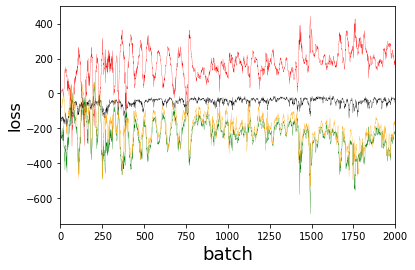

In [16]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [ ]:
import shutil
shutil.make_archive("/content/run/gan","zip","/content/run","gan")

In [ ]:
!cp /content/run/gan.zip /content/drive/MyDrive/gan/gangp

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/run/gan/0003_celeb/images/sample_*.png"
fp_out = "/content/run/gangp.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)